---

# Simplified access to Veluwe ecological data through OGC Web Services

**Author:** Hudson Passos  
**Internship host:** Netherlands Institute of Ecology (NIOO-KNAW)  
**Host supervisor:** Stefan Vriend (NIOO-KNAW)  
**WUR supervisor:** Liesbeth Bakker (WUR, NIOO-KNAW)  
**Repository:** [research-project-internship-nioo](https://github.com/hudsonpassos/research-project-internship-nioo)  
**Date:** July 18, 2025  
**Python version:** 3.11.9  
**License:** MIT  
**Description:**  
This notebook is part of a research internship project. It focuses on the automated selection, filtering, 
and preprocessing of open ecological geospatial datasets for the Veluwe region using OGC Web Services (WCS and WFS).


---

# **Part 3**: Spatial and semantic filters

### 1.1. Initialization: packages, paths, and spatial inputs

**Packages**

In [1]:
import pandas as pd
import geopandas as gpd
import time
from PIL import Image
import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from owslib.csw import CatalogueServiceWeb
from owslib.ows import ServiceIdentification
import requests
from lxml import etree
import pandas as pd
import re
from fuzzywuzzy import fuzz
from shapely.geometry import box
import ast
from shapely.geometry import Point, Polygon
from shapely.ops import unary_union
import rasterio
import tempfile
from urllib.parse import urlencode
from urllib.parse import urlparse, urlunparse, urlencode

C:\Users\hudso\anaconda3\Lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


**Setting pathways**

In [2]:
root = "C:/Users/hudso/OneDrive/Documents/02. WUR/11. INTERNSHIP"
outlines_path = os.path.join(root, "02 data/outlines")
output_path = os.path.join(root, "05 python_project/output")

**Loading data frames**

In [3]:
df_wcs = pd.read_csv("checkpoint02_ngr_WCS_metadata.csv")
df_wfs = pd.read_csv("checkpoint02_ngr_WFS_metadata.csv")

**Loading outlines**

In [18]:
NLshp_path = os.path.join(outlines_path, "netherlands28992_outline.gpkg")
VELshp_path = os.path.join(outlines_path, "veluwe28992_outline.gpkg")

NLgdf = gpd.read_file(NLshp_path)
VELgdf = gpd.read_file(VELshp_path)

netherlands4326 = NLgdf.to_crs(epsg=4326)
netherlands28992 = NLgdf

veluwe4326 = VELgdf.to_crs(epsg=4326)
veluwe28992 = VELgdf

**Function to make the outline square**

In [15]:
def get_square_bounds(gdf, target_epsg=28992):
    """
    Computes a square bounding box centered on the original bounds of a GeoDataFrame.

    Parameters:
    - gdf: GeoDataFrame
    - target_epsg: EPSG code to reproject the GeoDataFrame before computing bounds (default: 28992)

    Returns:
    - square_bounds: NumPy array [minx, miny, maxx, maxy] of the square bounding box
    """
    # Project to desired CRS
    gdf_proj = gdf.to_crs(epsg=target_epsg)

    # Original bounds
    minx, miny, maxx, maxy = gdf_proj.total_bounds

    # Width and height
    width = maxx - minx
    height = maxy - miny

    # Max side length
    max_side = max(width, height)

    # Center coordinates
    center_x = (minx + maxx) / 2
    center_y = (miny + maxy) / 2

    # Square bounds
    half_side = max_side / 2
    square_bounds = np.array([
        center_x - half_side,
        center_y - half_side,
        center_x + half_side,
        center_y + half_side
    ])

    return square_bounds


In [16]:
square_bounds_VEL = get_square_bounds(VELgdf)

**Plot**

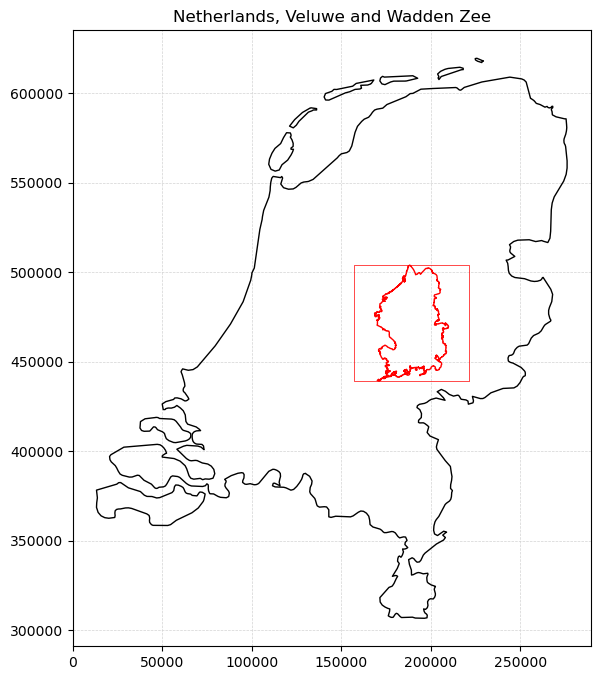

In [17]:
# Create a single figure and axis
fig, ax = plt.subplots(figsize=(8, 8))

# Plot Netherlands border
netherlands28992.boundary.plot(ax=ax, color='black', linewidth=1)

# Plot Veluwe border
veluwe28992.boundary.plot(ax=ax, color='red', linewidth=1)

bbox_polygon_VEL = box(*square_bounds_VEL)  # minx, miny, maxx, maxy
bbox_gdf_VEL = gpd.GeoDataFrame(geometry=[bbox_polygon_VEL], crs="EPSG:28992")
bbox_gdf_VEL.boundary.plot(ax=ax, color='red', linewidth=0.5)

# Optional: Add title or grid
ax.set_title("Netherlands, Veluwe and Wadden Zee")
ax.grid(True, color='lightgray', linestyle='--', linewidth=0.5)

plt.show()

### 1.2. Spatial filter 1:
Checking the intersection between the input outline (e.g., Veluwe) using **bounding box** from metadata. 

In [59]:
def transform_bbox_wgs84_to_28992(df, input_col, output_col):
    """
    Converts bounding box strings in WGS84 to bounding boxes in EPSG:28992.

    Parameters:
    - df: pandas DataFrame
    - input_col: name of the column containing bbox as strings (e.g. "('5.033', '52.251', '5.852', '53.082')")
    - output_col: name of the new column to store bbox tuples in EPSG:28992

    Returns:
    - DataFrame with a new column containing transformed bbox as (minx, miny, maxx, maxy) in EPSG:28992
    """
    transformed_bboxes = []

    for bbox_str in df[input_col]:
        try:
            # Parse the string to tuple of floats
            bbox_tuple = tuple(map(float, ast.literal_eval(bbox_str)))
            minx, miny, maxx, maxy = bbox_tuple

            # Create WGS84 geometry
            gdf = gpd.GeoDataFrame(
                geometry=[box(minx, miny, maxx, maxy)],
                crs="EPSG:4326"
            )

            # Transform to EPSG:28992
            gdf_28992 = gdf.to_crs(epsg=28992)
            transformed = gdf_28992.geometry.iloc[0].bounds  # (minx, miny, maxx, maxy)

            transformed_bboxes.append(transformed)
        except Exception as e:
            transformed_bboxes.append(None)

    df[output_col] = transformed_bboxes
    return df


In [60]:
def check_bbox_intersection_with_outline(outline_gdf, df, bbox_col, output_col="intersects_outline"):
    """
    Checks whether each bounding box in the given DataFrame intersects with the outline geometry.

    Parameters:
    - outline_gdf: GeoDataFrame with one or more geometries (in EPSG:28992)
    - df: DataFrame with bounding boxes (as tuples) in EPSG:28992
    - bbox_col: column in df that contains bounding boxes as tuples (minx, miny, maxx, maxy)
    - output_col: name of output column with boolean intersection result

    Returns:
    - DataFrame with new boolean column indicating intersection
    """
    # Ensure outline_gdf is valid and merged
    outline_geom = outline_gdf.unary_union  # merge multipolygons if needed

    results = []
    for bbox in df[bbox_col]:
        try:
            if bbox is None:
                results.append(False)
                continue
            bbox_geom = box(*bbox)
            intersects = outline_geom.intersects(bbox_geom)
            results.append(intersects)
        except:
            results.append(False)

    df[output_col] = results
    return df


**Transform bounding boxes from WGS84 to 28992:**

In [61]:
df_wcs = transform_bbox_wgs84_to_28992(df=df_wcs, input_col="bounding_box", output_col="bbox_28992")
df_wfs = transform_bbox_wgs84_to_28992(df=df_wfs, input_col="bounding_box", output_col="bbox_28992")

**Check intersection between study area and data bounding box**

In [62]:
df_wcs = check_bbox_intersection_with_outline(outline_gdf = veluwe28992, df = df_wcs, 
                                          bbox_col="bbox_28992", output_col="intersects_outline_1")

df_wfs = check_bbox_intersection_with_outline(outline_gdf = veluwe28992, df = df_wfs, 
                                          bbox_col="bbox_28992", output_col="intersects_outline_1")

In [63]:
df_wcs['intersects_outline_1'].value_counts()

intersects_outline_1
True     658
False    254
Name: count, dtype: int64

In [64]:
df_wfs['intersects_outline_1'].value_counts()

intersects_outline_1
False    2214
True     2001
Name: count, dtype: int64

**Filtering for Intersecting Data - 1**

In [65]:
df_wcs_sf1_clean = df_wcs[df_wcs['intersects_outline_1']==True]
df_wfs_sf1_clean = df_wfs[df_wfs['intersects_outline_1']==True]

In [66]:
len(df_wcs),len(df_wcs_sf1_clean)

(912, 658)

In [67]:
len(df_wfs),len(df_wfs_sf1_clean)

(4215, 2001)

**Checkpoint 03a sf1:**

In [68]:
# Saving
df_wcs_sf1_clean.to_csv("checkpoint03_sf1_ngr_WCS_metadata.csv", index=False)
df_wfs_sf1_clean.to_csv("checkpoint03_sf1_ngr_WFS_metadata.csv", index=False)

### 1.3. Spatial filter 2:
#### WCS:
Inspecting presence of data within the input outline (e.g., Veluwe) using **very small bounding boxes** to check. 

**Functions**

In [69]:
# Get centroids to check data inside study area:

def centroids_from_polygon_radially_splitted(gdf, n_polygons=5, ray_length=1e6):
    """
    Split a polygon into `n_polygons` radial wedges and return their centroids.

    Parameters:
    - gdf: GeoDataFrame with a single polygon (projected CRS, e.g., EPSG:28992)
    - n_polygons: number of radial wedge-shaped polygons
    - ray_length: length of the rays to ensure wedges intersect the polygon

    Returns:
    - GeoDataFrame of centroids, with 'part_id' column
    """
    # Ensure a single merged polygon
    polygon = unary_union(gdf.geometry)
    centroid = polygon.centroid

    angles = np.linspace(0, 2 * np.pi, n_polygons + 1)
    wedges = []

    for i in range(n_polygons):
        angle_start = angles[i]
        angle_end = angles[i+1]

        outer1 = Point(centroid.x + ray_length * np.cos(angle_start),
                       centroid.y + ray_length * np.sin(angle_start))
        outer2 = Point(centroid.x + ray_length * np.cos(angle_end),
                       centroid.y + ray_length * np.sin(angle_end))

        wedge = Polygon([centroid, outer1, outer2])
        clipped = polygon.intersection(wedge)
        if not clipped.is_empty:
            wedges.append(clipped)

    # Build GeoDataFrame and extract centroids
    wedges_gdf = gpd.GeoDataFrame({'part_id': range(1, len(wedges)+1),
                                    'geometry': wedges}, crs=gdf.crs)
    
    # Extract centroids
    centroids_gdf = wedges_gdf.copy()
    centroids_gdf["geometry"] = centroids_gdf.centroid

    return centroids_gdf


# From centroids, make small bboxes around it to detect data

def parse_resolution(res_str):
    try:
        return float(ast.literal_eval(res_str)[0])
    except:
        return None

def make_small_bboxes_from_centroids(centroids_gdf, series):
    
    # Filter to first valid downloadable row
    if series.empty:
        raise ValueError("No downloadable layer found in series.")
    
    res = parse_resolution(series["spatial_resolution"])
    if res is None:
        raise ValueError("Spatial resolution could not be parsed.")

    # Build list of bounding boxes around each centroid
    bboxes = []
    for point in centroids_gdf.geometry:
        x, y = point.x, point.y
        bbox = [x - res, y - res, x + res, y + res]
        bboxes.append(bbox)
    
    return bboxes
    
def detect_data_in_bbox(df, bbox, counter):
    """
    Downloads the raster for the given bbox and checks if it contains valid data.
    Valid data = not NaN and between -1,000,000 and 1,000,000.
    """
    #tqdm.write(f"intersect: {counter['valid']} / total {counter['valid'] + counter['notvalid']}")
    if (counter["valid"] + counter["notvalid"]) % 10 == 0:
        tqdm.write(f"intersect: {counter['valid']} / total {counter['valid'] + counter['notvalid']}")

    row = df.copy()
    layer = row["layer"]
    base_url = row["wcs_getcapabilities_url"].split("?")[0]
    crs = "EPSG:28992"

    # Get native resolution (X only)
    res_csv = round(float(row['spatial_resolution'].strip('()').split(', ')[0]), 6)
    
    # Axis label helper
    def get_axis_labels(wcs_base, cov_id):
        import xml.etree.ElementTree as ET
        ns = {"gml": "http://www.opengis.net/gml/3.2"}
        try:
            r = requests.get(wcs_base.replace("/ows", "/wcs"), params={
                "service": "WCS",
                "version": "2.0.1",
                "request": "DescribeCoverage",
                "coverageId": cov_id
            }, timeout=20)
            r.raise_for_status()
            root = ET.fromstring(r.content)
            env = root.find(".//gml:Envelope", ns)
            return env.attrib["axisLabels"].split()
        except Exception as e:
            print("⚠️ Axis label fetch failed, using fallback:", e)
            return ["x", "y"]

    x_label, y_label = get_axis_labels(base_url, layer)
    #print(f"ℹ️ Using axis labels: {x_label}, {y_label}")

    minx, miny, maxx, maxy = bbox

    params = {
        "service": "WCS",
        "version": "2.0.1",
        "request": "GetCoverage",
        "coverageId": layer,
        "format": "image/tiff",
        "subset": [f"{x_label}({minx},{maxx})", f"{y_label}({miny},{maxy})"],
        "subsettingcrs": crs,
        "outputcrs": crs,
        "resx": res_csv,
        "resy": res_csv
    }

    #print("📡 Sending WCS request...")
    try:
        r = requests.get(base_url, params=params, timeout=20)
        #print("WCS Request URL:", r.url)

        if "image" not in r.headers.get("Content-Type", "").lower():
            #print("❌ No image in response — bbox has no data.")
            return False

        with tempfile.NamedTemporaryFile(delete=False, suffix=".tif") as tmp_file:
            tmp_file.write(r.content)
            tmp_path = tmp_file.name

        # Open with rasterio and inspect pixel values
        with rasterio.open(tmp_path) as src:
            data = src.read(1, masked=True)  # read first band as masked array

        # Remove temp file
        os.remove(tmp_path)

        # Define valid value range
        lower_bound = -1_000_000
        upper_bound =  1_000_000

        # Check for valid (non-NaN and within range) pixels
        valid_pixels = np.ma.masked_invalid(data)
        mask = (valid_pixels >= lower_bound) & (valid_pixels <= upper_bound)

        if np.any(mask):
            #print("✅ BBox contains valid data.")
            counter["valid"] += 1
            return True
        else:
            #print("❌ BBox has only invalid/extreme values.")
            counter["notvalid"] += 1
            return False

    except requests.exceptions.ReadTimeout:
        #print("⚠️ Request timed out — assuming it has data.")
        valid_count = valid_count + 1
        return True
    except Exception as e:
        #print(f"⚠️ Request or parsing failed: {e}")
        notvalid_count = notvalid_count + 1
        return False
    
# Detect intersections:

def detect_coverage_intersections(df, centroids_gdf):
    """
    For each row in the DataFrame `df`, generate small bounding boxes around the centroids
    and check whether at least one bounding box contains data from the WCS layer.

    Adds a new boolean column `intersects_outline_2` to `df`.
    """
    counter = {"valid": 0, "notvalid": 0}
    
    # Initialize the result column
    df.loc[:, "intersects_outline_2"] = False

    # Iterate with a progress bar
    for idx in tqdm(df.index, desc="🔍 Checking WCS intersections"):
        try:
            row = df.loc[idx]
            bboxes = make_small_bboxes_from_centroids(centroids_gdf, row)
            found = any(detect_data_in_bbox(row, bbox, counter) for bbox in bboxes)
            df.at[idx, "intersects_outline_2"] = found
        except Exception as e:
            #print(f"⚠️ Error on row {idx}: {e}")
            df.at[idx, "intersects_outline_2"] = False  # Optional: or leave as NaN

    return df

In [70]:
points = centroids_from_polygon_radially_splitted(gdf=veluwe28992, n_polygons=5, ray_length=1e6)
#points.plot()

In [71]:
df_wcs_sf2 = detect_coverage_intersections(df_wcs_sf1_clean, points) 

C:\Users\hudso\AppData\Local\Temp\ipykernel_21536\3382361004.py:186: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, "intersects_outline_2"] = False
🔍 Checking WCS intersections:   0%|                                                           | 0/658 [00:00<?, ?it/s]

intersect: 0 / total 0


🔍 Checking WCS intersections:   0%|▏                                                  | 2/658 [00:07<12:13,  1.12s/it]

intersect: 1 / total 10


🔍 Checking WCS intersections:   1%|▍                                                  | 6/658 [00:09<11:58,  1.10s/it]

⚠️ Axis label fetch failed, using fallback: 400 Client Error: Bad Request for url: https://api.ellipsis-drive.com/v3/ogc/wcs/552c92e8-8422-46eb-bb55-1eb39e18eee9?service=WCS&version=2.0.1&request=DescribeCoverage&coverageId=a19ef596-c48b-479e-87f5-b808cf6fb4d3
⚠️ Axis label fetch failed, using fallback: 400 Client Error: Bad Request for url: https://api.ellipsis-drive.com/v3/ogc/wcs/552c92e8-8422-46eb-bb55-1eb39e18eee9?service=WCS&version=2.0.1&request=DescribeCoverage&coverageId=a19ef596-c48b-479e-87f5-b808cf6fb4d3
⚠️ Axis label fetch failed, using fallback: 400 Client Error: Bad Request for url: https://api.ellipsis-drive.com/v3/ogc/wcs/552c92e8-8422-46eb-bb55-1eb39e18eee9?service=WCS&version=2.0.1&request=DescribeCoverage&coverageId=a19ef596-c48b-479e-87f5-b808cf6fb4d3
⚠️ Axis label fetch failed, using fallback: 400 Client Error: Bad Request for url: https://api.ellipsis-drive.com/v3/ogc/wcs/552c92e8-8422-46eb-bb55-1eb39e18eee9?service=WCS&version=2.0.1&request=DescribeCoverage&cove

🔍 Checking WCS intersections:   1%|▌                                                  | 7/658 [00:10<10:38,  1.02it/s]

⚠️ Axis label fetch failed, using fallback: 400 Client Error: Bad Request for url: https://api.ellipsis-drive.com/v3/ogc/wcs/552c92e8-8422-46eb-bb55-1eb39e18eee9?service=WCS&version=2.0.1&request=DescribeCoverage&coverageId=a19ef596-c48b-479e-87f5-b808cf6fb4d3


🔍 Checking WCS intersections:   2%|█▏                                                | 15/658 [00:19<14:00,  1.31s/it]

intersect: 7 / total 20


🔍 Checking WCS intersections:   4%|█▉                                                | 25/658 [00:35<15:21,  1.46s/it]

intersect: 7 / total 30


🔍 Checking WCS intersections:   5%|██▌                                               | 33/658 [00:47<16:38,  1.60s/it]

intersect: 7 / total 40


🔍 Checking WCS intersections:   5%|██▌                                               | 33/658 [00:48<16:38,  1.60s/it]

intersect: 7 / total 40


🔍 Checking WCS intersections:   5%|██▌                                               | 33/658 [00:48<16:38,  1.60s/it]

intersect: 7 / total 40


🔍 Checking WCS intersections:   5%|██▌                                               | 34/658 [00:48<16:35,  1.60s/it]

intersect: 7 / total 40


🔍 Checking WCS intersections:   5%|██▌                                               | 34/658 [00:49<16:35,  1.60s/it]

intersect: 7 / total 40


🔍 Checking WCS intersections:   5%|██▌                                               | 34/658 [00:49<16:35,  1.60s/it]

intersect: 7 / total 40


🔍 Checking WCS intersections:   5%|██▌                                               | 34/658 [00:50<16:35,  1.60s/it]

intersect: 7 / total 40


🔍 Checking WCS intersections:   5%|██▌                                               | 34/658 [00:50<16:35,  1.60s/it]

intersect: 7 / total 40


🔍 Checking WCS intersections:   5%|██▋                                               | 35/658 [00:50<17:24,  1.68s/it]

intersect: 7 / total 40


🔍 Checking WCS intersections:   5%|██▋                                               | 35/658 [00:50<17:24,  1.68s/it]

intersect: 7 / total 40


🔍 Checking WCS intersections:   7%|███▎                                              | 43/658 [01:03<15:50,  1.54s/it]

intersect: 7 / total 50


🔍 Checking WCS intersections:   8%|████                                              | 54/658 [01:24<16:46,  1.67s/it]

intersect: 7 / total 60


🔍 Checking WCS intersections:   8%|████                                              | 54/658 [01:25<16:46,  1.67s/it]

intersect: 7 / total 60


🔍 Checking WCS intersections:   8%|████                                              | 54/658 [01:25<16:46,  1.67s/it]

intersect: 7 / total 60


🔍 Checking WCS intersections:   8%|████▏                                             | 55/658 [01:25<16:10,  1.61s/it]

intersect: 7 / total 60


🔍 Checking WCS intersections:   8%|████▏                                             | 55/658 [01:26<16:10,  1.61s/it]

intersect: 7 / total 60


🔍 Checking WCS intersections:   9%|████▋                                             | 61/658 [01:36<15:44,  1.58s/it]

intersect: 7 / total 70


🔍 Checking WCS intersections:  12%|██████                                            | 79/658 [02:03<13:59,  1.45s/it]

intersect: 7 / total 80


🔍 Checking WCS intersections:  12%|██████                                            | 79/658 [02:03<13:59,  1.45s/it]

intersect: 7 / total 80


🔍 Checking WCS intersections:  12%|██████                                            | 79/658 [02:03<13:59,  1.45s/it]

intersect: 7 / total 80


🔍 Checking WCS intersections:  12%|██████                                            | 80/658 [02:03<14:06,  1.46s/it]

intersect: 7 / total 80


🔍 Checking WCS intersections:  12%|██████                                            | 80/658 [02:04<14:06,  1.46s/it]

intersect: 7 / total 80


🔍 Checking WCS intersections:  15%|███████▍                                          | 98/658 [02:35<14:22,  1.54s/it]

intersect: 7 / total 90


🔍 Checking WCS intersections:  17%|████████                                         | 109/658 [02:52<13:33,  1.48s/it]

intersect: 7 / total 100


🔍 Checking WCS intersections:  17%|████████▎                                        | 112/658 [02:57<15:16,  1.68s/it]

intersect: 7 / total 110


🔍 Checking WCS intersections:  18%|████████▋                                        | 116/658 [03:02<09:18,  1.03s/it]

intersect: 10 / total 120


🔍 Checking WCS intersections:  19%|█████████▏                                       | 123/658 [03:13<13:22,  1.50s/it]

intersect: 10 / total 130


🔍 Checking WCS intersections:  20%|█████████▊                                       | 131/658 [03:27<14:20,  1.63s/it]

intersect: 11 / total 140


🔍 Checking WCS intersections:  21%|██████████▎                                      | 138/658 [03:39<16:01,  1.85s/it]

intersect: 11 / total 150


🔍 Checking WCS intersections:  21%|██████████▎                                      | 138/658 [03:39<16:01,  1.85s/it]

intersect: 11 / total 150


🔍 Checking WCS intersections:  21%|██████████▎                                      | 138/658 [03:39<16:01,  1.85s/it]

intersect: 11 / total 150


🔍 Checking WCS intersections:  21%|██████████▎                                      | 138/658 [03:39<16:01,  1.85s/it]

intersect: 11 / total 150


🔍 Checking WCS intersections:  21%|██████████▎                                      | 138/658 [03:40<16:01,  1.85s/it]

intersect: 11 / total 150


🔍 Checking WCS intersections:  21%|██████████▎                                      | 139/658 [03:40<14:47,  1.71s/it]

intersect: 11 / total 150


🔍 Checking WCS intersections:  21%|██████████▎                                      | 139/658 [03:40<14:47,  1.71s/it]

intersect: 11 / total 150


🔍 Checking WCS intersections:  21%|██████████▎                                      | 139/658 [03:41<14:47,  1.71s/it]

intersect: 11 / total 150


🔍 Checking WCS intersections:  21%|██████████▎                                      | 139/658 [03:41<14:47,  1.71s/it]

intersect: 11 / total 150


🔍 Checking WCS intersections:  21%|██████████▎                                      | 139/658 [03:41<14:47,  1.71s/it]

intersect: 11 / total 150


🔍 Checking WCS intersections:  21%|██████████▍                                      | 140/658 [03:41<14:04,  1.63s/it]

intersect: 11 / total 150


🔍 Checking WCS intersections:  21%|██████████▍                                      | 140/658 [03:42<14:04,  1.63s/it]

intersect: 11 / total 150


🔍 Checking WCS intersections:  21%|██████████▍                                      | 140/658 [03:42<14:04,  1.63s/it]

intersect: 11 / total 150


🔍 Checking WCS intersections:  21%|██████████▍                                      | 140/658 [03:42<14:04,  1.63s/it]

intersect: 11 / total 150


🔍 Checking WCS intersections:  21%|██████████▍                                      | 140/658 [03:43<14:04,  1.63s/it]

intersect: 11 / total 150


🔍 Checking WCS intersections:  21%|██████████▌                                      | 141/658 [03:43<13:46,  1.60s/it]

intersect: 11 / total 150


🔍 Checking WCS intersections:  21%|██████████▌                                      | 141/658 [03:43<13:46,  1.60s/it]

intersect: 11 / total 150


🔍 Checking WCS intersections:  21%|██████████▌                                      | 141/658 [03:44<13:46,  1.60s/it]

intersect: 11 / total 150


🔍 Checking WCS intersections:  21%|██████████▌                                      | 141/658 [03:44<13:46,  1.60s/it]

intersect: 11 / total 150


🔍 Checking WCS intersections:  21%|██████████▌                                      | 141/658 [03:44<13:46,  1.60s/it]

intersect: 11 / total 150


🔍 Checking WCS intersections:  22%|██████████▌                                      | 142/658 [03:44<13:30,  1.57s/it]

intersect: 11 / total 150


🔍 Checking WCS intersections:  22%|██████████▌                                      | 142/658 [03:45<13:30,  1.57s/it]

intersect: 11 / total 150


🔍 Checking WCS intersections:  22%|██████████▌                                      | 142/658 [03:45<13:30,  1.57s/it]

intersect: 11 / total 150


🔍 Checking WCS intersections:  22%|██████████▌                                      | 142/658 [03:45<13:30,  1.57s/it]

intersect: 11 / total 150


🔍 Checking WCS intersections:  22%|██████████▌                                      | 142/658 [03:46<13:30,  1.57s/it]

intersect: 11 / total 150


🔍 Checking WCS intersections:  22%|██████████▋                                      | 143/658 [03:46<13:17,  1.55s/it]

intersect: 11 / total 150


🔍 Checking WCS intersections:  22%|██████████▋                                      | 143/658 [03:46<13:17,  1.55s/it]

intersect: 11 / total 150


🔍 Checking WCS intersections:  22%|██████████▋                                      | 143/658 [03:47<13:17,  1.55s/it]

intersect: 11 / total 150


🔍 Checking WCS intersections:  22%|██████████▋                                      | 143/658 [03:47<13:17,  1.55s/it]

intersect: 11 / total 150


🔍 Checking WCS intersections:  22%|██████████▋                                      | 143/658 [03:47<13:17,  1.55s/it]

intersect: 11 / total 150


🔍 Checking WCS intersections:  22%|██████████▋                                      | 144/658 [03:47<13:00,  1.52s/it]

intersect: 11 / total 150


🔍 Checking WCS intersections:  22%|██████████▋                                      | 144/658 [03:48<13:00,  1.52s/it]

intersect: 11 / total 150


🔍 Checking WCS intersections:  23%|███████████▏                                     | 151/658 [04:02<16:28,  1.95s/it]C:\Users\hudso\AppData\Local\Temp\ipykernel_21536\3382361004.py:143: NodataShadowWarning: The dataset's nodata attribute is shadowing the alpha band. All masks will be determined by the nodata attribute
  data = src.read(1, masked=True)  # read first band as masked array
🔍 Checking WCS intersections:  24%|███████████▊                                     | 159/658 [04:14<11:42,  1.41s/it]

intersect: 12 / total 160


🔍 Checking WCS intersections:  26%|████████████▉                                    | 174/658 [04:37<12:47,  1.59s/it]

intersect: 12 / total 170


🔍 Checking WCS intersections:  26%|████████████▉                                    | 174/658 [04:37<12:47,  1.59s/it]

intersect: 12 / total 170


🔍 Checking WCS intersections:  26%|████████████▉                                    | 174/658 [04:37<12:47,  1.59s/it]

intersect: 12 / total 170


🔍 Checking WCS intersections:  27%|█████████████                                    | 175/658 [04:38<12:31,  1.56s/it]

intersect: 12 / total 170


🔍 Checking WCS intersections:  27%|█████████████                                    | 175/658 [04:38<12:31,  1.56s/it]

intersect: 12 / total 170


🔍 Checking WCS intersections:  27%|█████████████                                    | 175/658 [04:38<12:31,  1.56s/it]

intersect: 12 / total 170


🔍 Checking WCS intersections:  27%|█████████████                                    | 175/658 [04:39<12:31,  1.56s/it]

intersect: 12 / total 170


🔍 Checking WCS intersections:  27%|█████████████                                    | 175/658 [04:39<12:31,  1.56s/it]

intersect: 12 / total 170


🔍 Checking WCS intersections:  27%|█████████████                                    | 176/658 [04:39<12:11,  1.52s/it]

intersect: 12 / total 170


🔍 Checking WCS intersections:  27%|█████████████                                    | 176/658 [04:39<12:11,  1.52s/it]

intersect: 12 / total 170


🔍 Checking WCS intersections:  27%|█████████████                                    | 176/658 [04:40<12:11,  1.52s/it]

intersect: 12 / total 170


🔍 Checking WCS intersections:  27%|█████████████                                    | 176/658 [04:40<12:11,  1.52s/it]

intersect: 12 / total 170


🔍 Checking WCS intersections:  27%|█████████████                                    | 176/658 [04:40<12:11,  1.52s/it]

intersect: 12 / total 170


🔍 Checking WCS intersections:  27%|█████████████▏                                   | 177/658 [04:41<12:05,  1.51s/it]

intersect: 12 / total 170


🔍 Checking WCS intersections:  27%|█████████████▏                                   | 177/658 [04:41<12:05,  1.51s/it]

intersect: 12 / total 170


🔍 Checking WCS intersections:  27%|█████████████▏                                   | 177/658 [04:41<12:05,  1.51s/it]

intersect: 12 / total 170


🔍 Checking WCS intersections:  27%|█████████████▏                                   | 177/658 [04:42<12:05,  1.51s/it]

intersect: 12 / total 170


🔍 Checking WCS intersections:  27%|█████████████▏                                   | 177/658 [04:42<12:05,  1.51s/it]

intersect: 12 / total 170


🔍 Checking WCS intersections:  27%|█████████████▎                                   | 178/658 [04:42<12:18,  1.54s/it]

intersect: 12 / total 170


🔍 Checking WCS intersections:  27%|█████████████▎                                   | 178/658 [04:42<12:18,  1.54s/it]

intersect: 12 / total 170


🔍 Checking WCS intersections:  34%|████████████████▌                                | 222/658 [05:58<10:22,  1.43s/it]

intersect: 12 / total 180


🔍 Checking WCS intersections:  34%|████████████████▌                                | 222/658 [05:58<10:22,  1.43s/it]

intersect: 12 / total 180


🔍 Checking WCS intersections:  34%|████████████████▌                                | 222/658 [05:58<10:22,  1.43s/it]

intersect: 12 / total 180


🔍 Checking WCS intersections:  34%|████████████████▌                                | 223/658 [05:58<10:21,  1.43s/it]

intersect: 12 / total 180


🔍 Checking WCS intersections:  34%|████████████████▌                                | 223/658 [05:59<10:21,  1.43s/it]

intersect: 12 / total 180


🔍 Checking WCS intersections:  35%|█████████████████▎                               | 233/658 [06:14<10:34,  1.49s/it]

intersect: 13 / total 190


🔍 Checking WCS intersections:  38%|██████████████████▍                              | 247/658 [06:35<09:48,  1.43s/it]

intersect: 13 / total 200


🔍 Checking WCS intersections:  38%|██████████████████▋                              | 251/658 [06:43<11:10,  1.65s/it]

intersect: 13 / total 210


🔍 Checking WCS intersections:  39%|███████████████████▏                             | 258/658 [06:55<10:20,  1.55s/it]

intersect: 13 / total 220


🔍 Checking WCS intersections:  40%|███████████████████▊                             | 266/658 [07:07<10:36,  1.62s/it]

intersect: 13 / total 230


🔍 Checking WCS intersections:  40%|███████████████████▊                             | 266/658 [07:07<10:36,  1.62s/it]

intersect: 13 / total 230


🔍 Checking WCS intersections:  40%|███████████████████▊                             | 266/658 [07:08<10:36,  1.62s/it]

intersect: 13 / total 230


🔍 Checking WCS intersections:  43%|████████████████████▊                            | 280/658 [07:28<09:26,  1.50s/it]

intersect: 13 / total 240


🔍 Checking WCS intersections:  43%|████████████████████▊                            | 280/658 [07:28<09:26,  1.50s/it]

intersect: 13 / total 240


🔍 Checking WCS intersections:  43%|████████████████████▊                            | 280/658 [07:29<09:26,  1.50s/it]

intersect: 13 / total 240


🔍 Checking WCS intersections:  43%|████████████████████▉                            | 281/658 [07:29<09:21,  1.49s/it]

intersect: 13 / total 240


🔍 Checking WCS intersections:  43%|████████████████████▉                            | 281/658 [07:29<09:21,  1.49s/it]

intersect: 13 / total 240


🔍 Checking WCS intersections:  43%|████████████████████▉                            | 281/658 [07:29<09:21,  1.49s/it]

intersect: 13 / total 240


🔍 Checking WCS intersections:  43%|████████████████████▉                            | 281/658 [07:30<09:21,  1.49s/it]

intersect: 13 / total 240


🔍 Checking WCS intersections:  43%|████████████████████▉                            | 281/658 [07:30<09:21,  1.49s/it]

intersect: 13 / total 240


🔍 Checking WCS intersections:  43%|█████████████████████                            | 282/658 [07:30<09:12,  1.47s/it]

intersect: 13 / total 240


🔍 Checking WCS intersections:  44%|█████████████████████▋                           | 291/658 [07:45<09:21,  1.53s/it]

intersect: 13 / total 250


🔍 Checking WCS intersections:  44%|█████████████████████▋                           | 291/658 [07:45<09:21,  1.53s/it]

intersect: 13 / total 250


🔍 Checking WCS intersections:  44%|█████████████████████▋                           | 291/658 [07:46<09:21,  1.53s/it]

intersect: 13 / total 250


🔍 Checking WCS intersections:  44%|█████████████████████▋                           | 292/658 [07:46<09:11,  1.51s/it]

intersect: 13 / total 250


🔍 Checking WCS intersections:  44%|█████████████████████▋                           | 292/658 [07:46<09:11,  1.51s/it]

intersect: 13 / total 250


🔍 Checking WCS intersections:  44%|█████████████████████▋                           | 292/658 [07:46<09:11,  1.51s/it]

intersect: 13 / total 250


🔍 Checking WCS intersections:  44%|█████████████████████▋                           | 292/658 [07:47<09:11,  1.51s/it]

intersect: 13 / total 250


🔍 Checking WCS intersections:  44%|█████████████████████▋                           | 292/658 [07:47<09:11,  1.51s/it]

intersect: 13 / total 250


🔍 Checking WCS intersections:  45%|█████████████████████▊                           | 293/658 [07:47<09:03,  1.49s/it]

intersect: 13 / total 250


🔍 Checking WCS intersections:  47%|██████████████████████▊                          | 307/658 [08:08<08:40,  1.48s/it]

intersect: 14 / total 260


🔍 Checking WCS intersections:  47%|██████████████████████▊                          | 307/658 [08:08<08:40,  1.48s/it]

intersect: 14 / total 260


🔍 Checking WCS intersections:  47%|██████████████████████▊                          | 307/658 [08:08<08:40,  1.48s/it]

intersect: 14 / total 260


🔍 Checking WCS intersections:  47%|██████████████████████▉                          | 308/658 [08:09<08:41,  1.49s/it]

intersect: 14 / total 260


🔍 Checking WCS intersections:  48%|███████████████████████▎                         | 313/658 [08:20<07:34,  1.32s/it]

intersect: 15 / total 270


🔍 Checking WCS intersections:  48%|███████████████████████▌                         | 316/658 [08:26<12:40,  2.22s/it]

intersect: 15 / total 280


🔍 Checking WCS intersections:  49%|███████████████████████▉                         | 322/658 [08:37<10:47,  1.93s/it]

intersect: 15 / total 290


🔍 Checking WCS intersections:  49%|███████████████████████▉                         | 322/658 [08:37<10:47,  1.93s/it]

intersect: 15 / total 290


🔍 Checking WCS intersections:  49%|███████████████████████▉                         | 322/658 [08:38<10:47,  1.93s/it]

intersect: 15 / total 290


🔍 Checking WCS intersections:  49%|████████████████████████                         | 323/658 [08:38<09:57,  1.78s/it]

intersect: 15 / total 290


🔍 Checking WCS intersections:  49%|████████████████████████                         | 323/658 [08:38<09:57,  1.78s/it]

intersect: 15 / total 290


🔍 Checking WCS intersections:  49%|████████████████████████                         | 323/658 [08:39<09:57,  1.78s/it]

intersect: 15 / total 290


🔍 Checking WCS intersections:  49%|████████████████████████                         | 323/658 [08:39<09:57,  1.78s/it]

intersect: 15 / total 290


🔍 Checking WCS intersections:  49%|████████████████████████                         | 323/658 [08:39<09:57,  1.78s/it]

intersect: 15 / total 290


🔍 Checking WCS intersections:  49%|████████████████████████▏                        | 324/658 [08:40<09:43,  1.75s/it]

intersect: 15 / total 290


🔍 Checking WCS intersections:  49%|████████████████████████▏                        | 324/658 [08:40<09:43,  1.75s/it]

intersect: 15 / total 290


🔍 Checking WCS intersections:  49%|████████████████████████▏                        | 324/658 [08:40<09:43,  1.75s/it]

intersect: 15 / total 290


🔍 Checking WCS intersections:  49%|████████████████████████▏                        | 324/658 [08:41<09:43,  1.75s/it]

intersect: 15 / total 290


🔍 Checking WCS intersections:  49%|████████████████████████▏                        | 324/658 [08:41<09:43,  1.75s/it]

intersect: 15 / total 290


🔍 Checking WCS intersections:  49%|████████████████████████▏                        | 325/658 [08:41<09:19,  1.68s/it]

intersect: 15 / total 290


🔍 Checking WCS intersections:  49%|████████████████████████▏                        | 325/658 [08:41<09:19,  1.68s/it]

intersect: 15 / total 290


🔍 Checking WCS intersections:  49%|████████████████████████▏                        | 325/658 [08:42<09:19,  1.68s/it]

intersect: 15 / total 290


🔍 Checking WCS intersections:  49%|████████████████████████▏                        | 325/658 [08:42<09:19,  1.68s/it]

intersect: 15 / total 290


🔍 Checking WCS intersections:  49%|████████████████████████▏                        | 325/658 [08:42<09:19,  1.68s/it]

intersect: 15 / total 290


🔍 Checking WCS intersections:  50%|████████████████████████▎                        | 326/658 [08:42<08:52,  1.60s/it]

intersect: 15 / total 290


🔍 Checking WCS intersections:  50%|████████████████████████▎                        | 326/658 [08:43<08:52,  1.60s/it]

intersect: 15 / total 290


🔍 Checking WCS intersections:  50%|████████████████████████▎                        | 326/658 [08:43<08:52,  1.60s/it]

intersect: 15 / total 290


🔍 Checking WCS intersections:  50%|████████████████████████▎                        | 326/658 [08:43<08:52,  1.60s/it]

intersect: 15 / total 290


🔍 Checking WCS intersections:  50%|████████████████████████▎                        | 326/658 [08:44<08:52,  1.60s/it]

intersect: 15 / total 290


🔍 Checking WCS intersections:  50%|████████████████████████▎                        | 327/658 [08:44<08:27,  1.53s/it]

intersect: 15 / total 290


🔍 Checking WCS intersections:  50%|████████████████████████▎                        | 327/658 [08:44<08:27,  1.53s/it]

intersect: 15 / total 290


🔍 Checking WCS intersections:  50%|████████████████████████▎                        | 327/658 [08:44<08:27,  1.53s/it]

intersect: 15 / total 290


🔍 Checking WCS intersections:  50%|████████████████████████▎                        | 327/658 [08:45<08:27,  1.53s/it]

intersect: 15 / total 290


🔍 Checking WCS intersections:  50%|████████████████████████▎                        | 327/658 [08:45<08:27,  1.53s/it]

intersect: 15 / total 290


🔍 Checking WCS intersections:  50%|████████████████████████▍                        | 328/658 [08:45<08:16,  1.50s/it]

intersect: 15 / total 290


🔍 Checking WCS intersections:  50%|████████████████████████▍                        | 328/658 [08:46<08:16,  1.50s/it]

intersect: 15 / total 290


🔍 Checking WCS intersections:  50%|████████████████████████▍                        | 328/658 [08:46<08:16,  1.50s/it]

intersect: 15 / total 290


🔍 Checking WCS intersections:  50%|████████████████████████▍                        | 328/658 [08:46<08:16,  1.50s/it]

intersect: 15 / total 290


🔍 Checking WCS intersections:  50%|████████████████████████▍                        | 328/658 [08:47<08:16,  1.50s/it]

intersect: 15 / total 290


🔍 Checking WCS intersections:  50%|████████████████████████▌                        | 329/658 [08:47<08:15,  1.51s/it]

intersect: 15 / total 290


🔍 Checking WCS intersections:  50%|████████████████████████▌                        | 329/658 [08:47<08:15,  1.51s/it]

intersect: 15 / total 290


🔍 Checking WCS intersections:  50%|████████████████████████▌                        | 329/658 [08:47<08:15,  1.51s/it]

intersect: 15 / total 290


🔍 Checking WCS intersections:  50%|████████████████████████▌                        | 329/658 [08:48<08:15,  1.51s/it]

intersect: 15 / total 290


🔍 Checking WCS intersections:  50%|████████████████████████▌                        | 329/658 [08:48<08:15,  1.51s/it]

intersect: 15 / total 290


🔍 Checking WCS intersections:  50%|████████████████████████▌                        | 330/658 [08:48<08:09,  1.49s/it]

intersect: 15 / total 290


🔍 Checking WCS intersections:  50%|████████████████████████▌                        | 330/658 [08:49<08:09,  1.49s/it]

intersect: 15 / total 290


🔍 Checking WCS intersections:  52%|█████████████████████████▋                       | 345/658 [09:10<07:27,  1.43s/it]

intersect: 16 / total 300


🔍 Checking WCS intersections:  52%|█████████████████████████▋                       | 345/658 [09:11<07:27,  1.43s/it]

intersect: 16 / total 300


🔍 Checking WCS intersections:  52%|█████████████████████████▋                       | 345/658 [09:11<07:27,  1.43s/it]

intersect: 16 / total 300


🔍 Checking WCS intersections:  53%|█████████████████████████▊                       | 346/658 [09:11<07:31,  1.45s/it]

intersect: 16 / total 300


🔍 Checking WCS intersections:  53%|█████████████████████████▊                       | 346/658 [09:12<07:31,  1.45s/it]

intersect: 16 / total 300


🔍 Checking WCS intersections:  55%|███████████████████████████                      | 363/658 [09:38<07:23,  1.50s/it]

intersect: 16 / total 310


🔍 Checking WCS intersections:  55%|███████████████████████████                      | 363/658 [09:38<07:23,  1.50s/it]

intersect: 16 / total 310


🔍 Checking WCS intersections:  57%|███████████████████████████▋                     | 372/658 [09:51<07:03,  1.48s/it]

intersect: 16 / total 320


🔍 Checking WCS intersections:  57%|████████████████████████████                     | 377/658 [10:00<08:00,  1.71s/it]

intersect: 16 / total 330


🔍 Checking WCS intersections:  59%|████████████████████████████▊                    | 387/658 [10:15<08:12,  1.82s/it]

intersect: 16 / total 340


🔍 Checking WCS intersections:  61%|█████████████████████████████▋                   | 399/658 [10:34<06:24,  1.48s/it]

intersect: 16 / total 350


🔍 Checking WCS intersections:  63%|██████████████████████████████▉                  | 415/658 [10:59<05:54,  1.46s/it]

intersect: 16 / total 360


🔍 Checking WCS intersections:  63%|██████████████████████████████▉                  | 415/658 [10:59<05:54,  1.46s/it]

intersect: 16 / total 360


🔍 Checking WCS intersections:  63%|██████████████████████████████▉                  | 415/658 [10:59<05:54,  1.46s/it]

intersect: 16 / total 360


🔍 Checking WCS intersections:  63%|██████████████████████████████▉                  | 416/658 [11:00<06:00,  1.49s/it]

intersect: 16 / total 360


🔍 Checking WCS intersections:  63%|██████████████████████████████▉                  | 416/658 [11:00<06:00,  1.49s/it]

intersect: 16 / total 360


🔍 Checking WCS intersections:  63%|██████████████████████████████▉                  | 416/658 [11:00<06:00,  1.49s/it]

intersect: 16 / total 360


🔍 Checking WCS intersections:  63%|██████████████████████████████▉                  | 416/658 [11:01<06:00,  1.49s/it]

intersect: 16 / total 360


🔍 Checking WCS intersections:  63%|██████████████████████████████▉                  | 416/658 [11:01<06:00,  1.49s/it]

intersect: 16 / total 360


🔍 Checking WCS intersections:  63%|███████████████████████████████                  | 417/658 [11:01<05:56,  1.48s/it]

intersect: 16 / total 360


🔍 Checking WCS intersections:  63%|███████████████████████████████                  | 417/658 [11:01<05:56,  1.48s/it]

intersect: 16 / total 360


🔍 Checking WCS intersections:  63%|███████████████████████████████                  | 417/658 [11:02<05:56,  1.48s/it]

intersect: 16 / total 360


🔍 Checking WCS intersections:  63%|███████████████████████████████                  | 417/658 [11:02<05:56,  1.48s/it]

intersect: 16 / total 360


🔍 Checking WCS intersections:  63%|███████████████████████████████                  | 417/658 [11:02<05:56,  1.48s/it]

intersect: 16 / total 360


🔍 Checking WCS intersections:  64%|███████████████████████████████▏                 | 418/658 [11:03<05:58,  1.50s/it]

intersect: 16 / total 360


🔍 Checking WCS intersections:  64%|███████████████████████████████▏                 | 418/658 [11:03<05:58,  1.50s/it]

intersect: 16 / total 360


🔍 Checking WCS intersections:  64%|███████████████████████████████▏                 | 418/658 [11:03<05:58,  1.50s/it]

intersect: 16 / total 360


🔍 Checking WCS intersections:  64%|███████████████████████████████▏                 | 418/658 [11:04<05:58,  1.50s/it]

intersect: 16 / total 360


🔍 Checking WCS intersections:  64%|███████████████████████████████▏                 | 418/658 [11:04<05:58,  1.50s/it]

intersect: 16 / total 360


🔍 Checking WCS intersections:  64%|███████████████████████████████▏                 | 419/658 [11:04<05:48,  1.46s/it]

intersect: 16 / total 360


🔍 Checking WCS intersections:  64%|███████████████████████████████▌                 | 423/658 [11:13<06:19,  1.62s/it]

intersect: 16 / total 370


🔍 Checking WCS intersections:  67%|████████████████████████████████▋                | 439/658 [11:38<06:05,  1.67s/it]

intersect: 16 / total 380


🔍 Checking WCS intersections:  69%|█████████████████████████████████▊               | 454/658 [11:59<04:46,  1.40s/it]

intersect: 17 / total 390


🔍 Checking WCS intersections:  69%|█████████████████████████████████▊               | 454/658 [11:59<04:46,  1.40s/it]

intersect: 17 / total 390


🔍 Checking WCS intersections:  69%|██████████████████████████████████               | 457/658 [12:01<03:40,  1.10s/it]

⚠️ Axis label fetch failed, using fallback: 400 Client Error: Bad Request for url: https://api.ellipsis-drive.com/v3/ogc/wcs/94037eea-4196-48db-9f83-0ef330a7655e?service=WCS&version=2.0.1&request=DescribeCoverage&coverageId=7daaa215-4cd0-48cd-9484-2eb5cec674e1
⚠️ Axis label fetch failed, using fallback: 400 Client Error: Bad Request for url: https://api.ellipsis-drive.com/v3/ogc/wcs/94037eea-4196-48db-9f83-0ef330a7655e?service=WCS&version=2.0.1&request=DescribeCoverage&coverageId=7daaa215-4cd0-48cd-9484-2eb5cec674e1
⚠️ Axis label fetch failed, using fallback: 400 Client Error: Bad Request for url: https://api.ellipsis-drive.com/v3/ogc/wcs/94037eea-4196-48db-9f83-0ef330a7655e?service=WCS&version=2.0.1&request=DescribeCoverage&coverageId=7daaa215-4cd0-48cd-9484-2eb5cec674e1
⚠️ Axis label fetch failed, using fallback: 400 Client Error: Bad Request for url: https://api.ellipsis-drive.com/v3/ogc/wcs/94037eea-4196-48db-9f83-0ef330a7655e?service=WCS&version=2.0.1&request=DescribeCoverage&cove

🔍 Checking WCS intersections:  70%|██████████████████████████████████               | 458/658 [12:02<03:18,  1.01it/s]

⚠️ Axis label fetch failed, using fallback: 400 Client Error: Bad Request for url: https://api.ellipsis-drive.com/v3/ogc/wcs/94037eea-4196-48db-9f83-0ef330a7655e?service=WCS&version=2.0.1&request=DescribeCoverage&coverageId=7daaa215-4cd0-48cd-9484-2eb5cec674e1


🔍 Checking WCS intersections:  71%|██████████████████████████████████▌              | 464/658 [12:10<04:57,  1.53s/it]

intersect: 18 / total 400


🔍 Checking WCS intersections:  73%|███████████████████████████████████▉             | 482/658 [12:38<04:18,  1.47s/it]

intersect: 19 / total 410


🔍 Checking WCS intersections:  74%|████████████████████████████████████▍            | 490/658 [12:49<04:17,  1.53s/it]

intersect: 19 / total 420


🔍 Checking WCS intersections:  74%|████████████████████████████████████▍            | 490/658 [12:49<04:17,  1.53s/it]

intersect: 19 / total 420


🔍 Checking WCS intersections:  74%|████████████████████████████████████▍            | 490/658 [12:50<04:17,  1.53s/it]

intersect: 19 / total 420


🔍 Checking WCS intersections:  74%|████████████████████████████████████▍            | 490/658 [12:50<04:17,  1.53s/it]

intersect: 19 / total 420


🔍 Checking WCS intersections:  74%|████████████████████████████████████▍            | 490/658 [12:50<04:17,  1.53s/it]

intersect: 19 / total 420


🔍 Checking WCS intersections:  75%|████████████████████████████████████▌            | 491/658 [12:51<04:09,  1.49s/it]

intersect: 19 / total 420


🔍 Checking WCS intersections:  75%|████████████████████████████████████▌            | 491/658 [12:51<04:09,  1.49s/it]

intersect: 19 / total 420


🔍 Checking WCS intersections:  76%|█████████████████████████████████████            | 497/658 [13:03<06:29,  2.42s/it]

intersect: 19 / total 430


🔍 Checking WCS intersections:  76%|█████████████████████████████████████            | 497/658 [13:03<06:29,  2.42s/it]

intersect: 19 / total 430


🔍 Checking WCS intersections:  78%|██████████████████████████████████████▍          | 516/658 [13:32<03:25,  1.45s/it]

intersect: 19 / total 440


🔍 Checking WCS intersections:  80%|███████████████████████████████████████▍         | 529/658 [13:50<03:00,  1.40s/it]

intersect: 20 / total 450


🔍 Checking WCS intersections:  81%|███████████████████████████████████████▉         | 536/658 [14:01<03:29,  1.72s/it]

intersect: 20 / total 460


🔍 Checking WCS intersections:  83%|████████████████████████████████████████▌        | 545/658 [14:14<02:01,  1.07s/it]

intersect: 22 / total 470


🔍 Checking WCS intersections:  84%|█████████████████████████████████████████        | 552/658 [14:24<02:52,  1.63s/it]

intersect: 22 / total 480


🔍 Checking WCS intersections:  84%|█████████████████████████████████████████▎       | 555/658 [14:30<02:48,  1.64s/it]

intersect: 22 / total 490


🔍 Checking WCS intersections:  85%|█████████████████████████████████████████▍       | 557/658 [14:34<03:10,  1.88s/it]

intersect: 22 / total 500


🔍 Checking WCS intersections:  85%|█████████████████████████████████████████▊       | 562/658 [14:43<02:33,  1.60s/it]

intersect: 22 / total 510


🔍 Checking WCS intersections:  86%|█████████████████████████████████████████▉       | 563/658 [14:44<02:55,  1.85s/it]

⚠️ Axis label fetch failed, using fallback: 400 Client Error: Bad Request for url: https://api.ellipsis-drive.com/v3/ogc/wcs/e96b10b9-e964-414c-958c-57a9dbe24e62?service=WCS&version=2.0.1&request=DescribeCoverage&coverageId=f380e0a0-4446-4d79-b2d1-3d4df40cbc93
⚠️ Axis label fetch failed, using fallback: 400 Client Error: Bad Request for url: https://api.ellipsis-drive.com/v3/ogc/wcs/e96b10b9-e964-414c-958c-57a9dbe24e62?service=WCS&version=2.0.1&request=DescribeCoverage&coverageId=f380e0a0-4446-4d79-b2d1-3d4df40cbc93
⚠️ Axis label fetch failed, using fallback: 400 Client Error: Bad Request for url: https://api.ellipsis-drive.com/v3/ogc/wcs/e96b10b9-e964-414c-958c-57a9dbe24e62?service=WCS&version=2.0.1&request=DescribeCoverage&coverageId=f380e0a0-4446-4d79-b2d1-3d4df40cbc93
⚠️ Axis label fetch failed, using fallback: 400 Client Error: Bad Request for url: https://api.ellipsis-drive.com/v3/ogc/wcs/e96b10b9-e964-414c-958c-57a9dbe24e62?service=WCS&version=2.0.1&request=DescribeCoverage&cove

🔍 Checking WCS intersections:  86%|██████████████████████████████████████████       | 564/658 [14:44<02:22,  1.52s/it]

⚠️ Axis label fetch failed, using fallback: 400 Client Error: Bad Request for url: https://api.ellipsis-drive.com/v3/ogc/wcs/e96b10b9-e964-414c-958c-57a9dbe24e62?service=WCS&version=2.0.1&request=DescribeCoverage&coverageId=f380e0a0-4446-4d79-b2d1-3d4df40cbc93


🔍 Checking WCS intersections:  87%|██████████████████████████████████████████▋      | 574/658 [15:00<02:06,  1.51s/it]

intersect: 23 / total 520


🔍 Checking WCS intersections:  90%|████████████████████████████████████████████     | 591/658 [15:24<01:40,  1.50s/it]

intersect: 25 / total 530


🔍 Checking WCS intersections:  91%|████████████████████████████████████████████▌    | 598/658 [15:35<01:18,  1.30s/it]

intersect: 25 / total 540


🔍 Checking WCS intersections:  91%|████████████████████████████████████████████▌    | 598/658 [15:35<01:18,  1.30s/it]

intersect: 25 / total 540


🔍 Checking WCS intersections:  91%|████████████████████████████████████████████▌    | 598/658 [15:35<01:18,  1.30s/it]

intersect: 25 / total 540


🔍 Checking WCS intersections:  91%|████████████████████████████████████████████▌    | 599/658 [15:36<01:18,  1.32s/it]

intersect: 25 / total 540


🔍 Checking WCS intersections:  91%|████████████████████████████████████████████▌    | 599/658 [15:36<01:18,  1.32s/it]

intersect: 25 / total 540


🔍 Checking WCS intersections:  96%|██████████████████████████████████████████████▉  | 630/658 [16:22<00:29,  1.06s/it]

intersect: 27 / total 550


🔍 Checking WCS intersections:  96%|██████████████████████████████████████████████▉  | 630/658 [16:22<00:29,  1.06s/it]

intersect: 27 / total 550


🔍 Checking WCS intersections:  96%|██████████████████████████████████████████████▉  | 630/658 [16:22<00:29,  1.06s/it]

intersect: 27 / total 550


🔍 Checking WCS intersections:  96%|██████████████████████████████████████████████▉  | 631/658 [16:22<00:32,  1.19s/it]

intersect: 27 / total 550


🔍 Checking WCS intersections:  96%|██████████████████████████████████████████████▉  | 631/658 [16:23<00:32,  1.19s/it]

intersect: 27 / total 550


🔍 Checking WCS intersections:  96%|██████████████████████████████████████████████▉  | 631/658 [16:23<00:32,  1.19s/it]

intersect: 27 / total 550


🔍 Checking WCS intersections:  96%|██████████████████████████████████████████████▉  | 631/658 [16:23<00:32,  1.19s/it]

intersect: 27 / total 550


🔍 Checking WCS intersections:  96%|██████████████████████████████████████████████▉  | 631/658 [16:24<00:32,  1.19s/it]

intersect: 27 / total 550


🔍 Checking WCS intersections:  96%|███████████████████████████████████████████████  | 632/658 [16:24<00:33,  1.30s/it]

intersect: 27 / total 550


🔍 Checking WCS intersections:  96%|███████████████████████████████████████████████  | 632/658 [16:24<00:33,  1.30s/it]

intersect: 27 / total 550


🔍 Checking WCS intersections:  98%|███████████████████████████████████████████████▊ | 642/658 [16:38<00:23,  1.47s/it]

intersect: 28 / total 560


🔍 Checking WCS intersections:  98%|███████████████████████████████████████████████▊ | 642/658 [16:39<00:23,  1.47s/it]

intersect: 28 / total 560


🔍 Checking WCS intersections:  98%|███████████████████████████████████████████████▊ | 642/658 [16:39<00:23,  1.47s/it]

intersect: 28 / total 560


🔍 Checking WCS intersections:  98%|███████████████████████████████████████████████▉ | 643/658 [16:39<00:22,  1.48s/it]

intersect: 28 / total 560


🔍 Checking WCS intersections:  98%|███████████████████████████████████████████████▉ | 643/658 [16:39<00:22,  1.48s/it]

intersect: 28 / total 560


🔍 Checking WCS intersections: 100%|████████████████████████████████████████████████▊| 655/658 [16:59<00:04,  1.50s/it]

intersect: 28 / total 570


🔍 Checking WCS intersections: 100%|█████████████████████████████████████████████████| 658/658 [17:03<00:00,  1.56s/it]


**Filtering for Intersecting Data - 2**

In [72]:
df_wcs_sf2_clean = df_wcs_sf2[df_wcs_sf2['intersects_outline_2']==True]

**Checkpoint 03 sf2 (wcs):**

In [73]:
# Saving
df_wcs_sf2_clean.to_csv("checkpoint03_sf2_ngr_WCS_metadata.csv", index=False)

#### WFS:
Inspecting presence of data within the Veluwe outline by requesting **GetFeature** and **resultType': 'hits'** and sending the Veluwe bounding box. 

In [74]:
def get_base_wfs_url(full_url):
    parsed = urlparse(full_url)
    return urlunparse((parsed.scheme, parsed.netloc, parsed.path, '', '', ''))

In [75]:
def feature_exists_in_bbox(
    wfs_base_url,
    layer_name,
    bbox,
    crs='EPSG:28992',
    verbose=False
):
    """
    Checks whether a WFS layer contains at least one feature within the given bounding box.

    Parameters:
        wfs_base_url (str): Base WFS URL (without query parameters).
        layer_name (str): Feature type name (e.g., 'ank:d5b_beregeningslocaties').
        bbox (list): [xmin, ymin, xmax, ymax] in the specified CRS.
        crs (str): CRS of the BBOX (default 'EPSG:28992').
        verbose (bool): Print debug output.

    Returns:
        bool: True if at least one feature is found in the BBOX.
    """
    wfs_base_url = get_base_wfs_url(wfs_base_url)
    
    def build_url(version):
        bbox_str = ','.join(map(str, bbox))
        if version == "2.0.0":
            # Convert EPSG:XXXX to URN format if needed
            if crs.upper().startswith("EPSG:"):
                urn_crs = f"urn:ogc:def:crs:{crs.replace(':', '::')}"
            else:
                urn_crs = crs
            bbox_str += f",{urn_crs}"
            params = {
                'service': 'WFS',
                'version': version,
                'request': 'GetFeature',
                'typenames': layer_name,
                'resultType': 'hits',
                'bbox': bbox_str
            }
        else:
            # WFS 1.1.0 does not accept CRS in bbox
            params = {
                'service': 'WFS',
                'version': version,
                'request': 'GetFeature',
                'typeName': layer_name,
                'resultType': 'hits',
                'bbox': bbox_str
            }
        return f"{wfs_base_url}?{urlencode(params)}", version

    for version in ["2.0.0", "1.1.0"]:
        url, version_used = build_url(version)
        if verbose:
            print(f"\n🌍 Checking WFS {version_used}")
            print(f"🔗 {url}")

        try:
            r = requests.get(url, timeout=20)
            r.raise_for_status()
            if verbose:
                print(f"📥 Response code: {r.status_code}")
                print(f"📄 First 300 chars:\n{r.text[:300]}")

            tree = etree.fromstring(r.content)
            if version == "2.0.0":
                count = tree.attrib.get("numberMatched")
            else:
                count = tree.attrib.get("numberOfFeatures")

            if verbose:
                print(f"📊 Feature count: {count}")

            if count and int(count) > 0:
                print("✅ Features found in BBOX.")
                return True

        except Exception as e:
            print(f"❌ Error with WFS {version_used}: {e}")
            continue

    print("❌ No features found or all requests failed.")
    return False

# Detect intersections:

def detect_feature_intersections(df, bbox):
    """
    Text
    """
    counter = {"valid": 0, "notvalid": 0}
    
    # Initialize the result column
    df.loc[:, "intersects_outline_2"] = False

    # Iterate with a progress bar
    for idx in tqdm(df.index, desc="Checking WFS intersections"):
        try:
            row = df.loc[idx]
            
            wfs_base_url = df.loc[idx,'wfs_getcapabilities_url']
            #print(wfs_base_url)
            layer_name = df.loc[idx,'layer']
            
            found = feature_exists_in_bbox(wfs_base_url=wfs_base_url, layer_name=layer_name, bbox=bbox)
            print(found)
            df.at[idx, "intersects_outline_2"] = found

        except Exception as e:
            #print(f"Error on row {idx}: {e}")
            df.at[idx, "intersects_outline_2"] = False  # Optional: or leave as NaN

    return df


In [76]:
def get_base_wfs_url(full_url):
    parsed = urlparse(full_url)
    return urlunparse((parsed.scheme, parsed.netloc, parsed.path, '', '', ''))

def feature_exists_in_bbox(
    wfs_base_url,
    layer_name,
    bbox,
    crs='EPSG:28992'
):
    wfs_base_url = get_base_wfs_url(wfs_base_url)

    def build_url(version):
        bbox_str = ','.join(map(str, bbox))
        if version == "2.0.0":
            if crs.upper().startswith("EPSG:"):
                urn_crs = f"urn:ogc:def:crs:{crs.replace(':', '::')}"
            else:
                urn_crs = crs
            bbox_str += f",{urn_crs}"
            params = {
                'service': 'WFS',
                'version': version,
                'request': 'GetFeature',
                'typenames': layer_name,
                'resultType': 'hits',
                'bbox': bbox_str
            }
        else:
            params = {
                'service': 'WFS',
                'version': version,
                'request': 'GetFeature',
                'typeName': layer_name,
                'resultType': 'hits',
                'bbox': bbox_str
            }
        return f"{wfs_base_url}?{urlencode(params)}"

    for version in ["2.0.0", "1.1.0"]:
        url = build_url(version)
        try:
            r = requests.get(url, timeout=20)
            r.raise_for_status()
            tree = etree.fromstring(r.content)
            count = tree.attrib.get("numberMatched") if version == "2.0.0" else tree.attrib.get("numberOfFeatures")
            if count and int(count) > 0:
                return True
        except:
            continue
    return False

def detect_feature_intersections(df, bbox):
    df = df.copy()
    df["intersects_outline_2"] = False
    valid_count = 0

    for idx in tqdm(df.index, desc="Checking WFS intersections"):
        try:
            row = df.loc[idx]
            wfs_base_url = row['wfs_getcapabilities_url']
            layer_name = row['layer']
            found = feature_exists_in_bbox(wfs_base_url, layer_name, bbox)
            df.at[idx, "intersects_outline_2"] = found
            if found:
                valid_count += 1
        except:
            df.at[idx, "intersects_outline_2"] = False

    total_checked = len(df)
    print(f"\n✅ Valid intersections: {valid_count} / {total_checked}")
    return df


In [77]:
df_wfs_sf2 = detect_feature_intersections(df_wfs_sf1_clean, bbox = veluwe28992.total_bounds)

Checking WFS intersections: 100%|██████████████████████████████████████████████████| 2001/2001 [15:18<00:00,  2.18it/s]


✅ Valid intersections: 1289 / 2001


**Filtering for Intersecting Data - 2**

In [78]:
df_wfs_sf2_clean = df_wfs_sf2[df_wfs_sf2['intersects_outline_2']==True]

**Checkpoint 03 sf2 (wfs):**

In [79]:
# Saving
df_wfs_sf2_clean.to_csv("checkpoint03_sf2_ngr_WFS_metadata.csv", index=False)

### 1.4. Content-based filter:
Matching input words with **keywords** & **abstract**.

**Functions**

In [80]:
# Function to add words from the column "abstract" to the "keywords"

def enrich_keywords_with_abstract(df: pd.DataFrame) -> pd.DataFrame:
    """
    Create a new column 'keywords_+' that merges the existing keywords in
    'keywords' with all alphanumeric tokens from 'abstract', separated by
    semicolons. The original 'keywords' column is left unchanged.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing at least 'keywords' and 'abstract' columns.

    Returns
    -------
    pd.DataFrame
        A copy of the input DataFrame with an additional 'keywords_+' column.
    """
    df = df.copy()  # avoid mutating the caller’s DataFrame

    def build_keywords_plus(row):
        # Parse the existing keywords
        existing_keywords = (
            row["keywords"].split(";") if pd.notna(row["keywords"]) else []
        )

        # Tokenize the abstract (alphanumeric only)
        abstract_words = (
            re.findall(r"\b\w+\b", row["abstract"].lower())
            if pd.notna(row["abstract"])
            else []
        )

        # Combine, deduplicate, and sort
        all_terms = [kw.strip() for kw in existing_keywords + abstract_words if kw.strip()]
        return ";".join(sorted(set(all_terms)))

    # Apply row-wise
    df["keywords_+"] = df.apply(build_keywords_plus, axis=1)

    return df

# Function to match words from the list (input) to the metadata data frame

def flag_fuzzy_keyword_matches(df, word_list, threshold=80):
    """
    Add a boolean column `has_fuzzy_keyword_match` to the DataFrame, where True indicates
    that at least one word from `word_list` matches a keyword in the 'keywords' column
    with a fuzzy ratio ≥ `threshold`.

    Parameters:
        df (pd.DataFrame): DataFrame with a 'keywords' column.
        word_list (list): List of words to match against.
        threshold (int): Minimum fuzzy match ratio (default: 80).
    """

    def match_keywords(cell):
        if pd.isna(cell):
            return False
        keywords = [kw.strip().lower() for kw in str(cell).split(';') if kw.strip()]
        for word in word_list:
            word = word.lower()
            for kw in keywords:
                if fuzz.ratio(word, kw) >= threshold:
                    return True
        return False

    df["has_fuzzy_keyword_match"] = df["keywords_+"].apply(match_keywords)
    return df


In [81]:
#df_wcs_sf2_clean = pd.read_csv("checkpoint03_sf2_ngr_WCS_metadata.csv")
#df_wfs_sf2_clean = pd.read_csv("checkpoint03_sf2_ngr_WFS_metadata.csv")

**Executing functions:**

In [82]:
word_list = ["landgebruik", "paden", "recreatievoorzieningen", "recreatie", "wegen", "barrières", "recreatiedichtheid",
"leefgebieden", "wildbeheer", "terrein eigenaars", "eigenaars", "roodwild", "tellingen", "wolf", "vegetatiekaarten", 
"vegetatie", "Recreatiezoneringsmaatregelen"]

#word_list = ["vegetation"]

In [83]:
# WCS
start = time.time()
df_wcs_sf2_clean = enrich_keywords_with_abstract(df_wcs_sf2_clean)
df_wcs_sf2_cf = flag_fuzzy_keyword_matches(df_wcs_sf2_clean, word_list)
df_wcs_sf2_cf_clean = df_wcs_sf2_cf[df_wcs_sf2_cf['has_fuzzy_keyword_match']==True]
end = time.time()
print(f"Content-based filtering for WCS records completed in {end - start:.2f} seconds.")

Content-based filtering for WCS records completed in 0.24 seconds.


In [84]:
# WFS
start = time.time()
df_wfs_sf2_clean = enrich_keywords_with_abstract(df_wfs_sf2_clean)
df_wfs_sf2_cf = flag_fuzzy_keyword_matches(df_wfs_sf2_clean, word_list)
df_wfs_sf2_cf_clean = df_wfs_sf2_cf[df_wfs_sf2_cf['has_fuzzy_keyword_match']==True]
end = time.time()
print(f"Content-based filtering for WFS records completed in {end - start:.2f} seconds.")

Content-based filtering for WFS records completed in 12.76 seconds.


In [85]:
df_wcs_sf2_cf_clean

,identifier,resource_type,md_standard,ogc_web_services,md_date,language,crs_epsg_codes,title,keywords,abstract,...,coverage_id,clean_coverage_id,layer,crs_epsg,spatial_resolution,bbox_28992,intersects_outline_1,intersects_outline_2,keywords_+,has_fuzzy_keyword_match
13,7f14c112-9004-43ec-8cf2-0ac54a253721,dataset,ISO 19115,WMS; WCS,2022-11-15,dut,28992,Natuurlijke ziekte- en plaagwering van de bode...,bodem,Wat ziet U: De natuurlijke ziekten- en plaagwe...,...,ank__rivm_r3_gm_diseasesupp,rivm_r3_gm_diseasesupp,ank__rivm_r3_gm_diseasesupp,28992,"(25.0, 25.0)","(12714.671780765639, 308707.4330927675, 283699...",True,True,20;belangrijk;bestrijding;bestrijdingsmiddelen...,True
28,c186ec2a-ca51-4d28-b2a8-d99ce886e145,dataset,ISO 19115,WMS; WCS,2022-11-17,dut,28992,Grootschalige stikstofdepositie Nederland,stikstofdepositie,Wat ziet u? De depositie van stikstofverbindin...,...,ank__rivm_r19_gm_n-depositie,rivm_r19_gm_n-depositie,ank__rivm_r19_gm_n-depositie,28992,"(1000.0, 1000.0)","(12714.671780765639, 308707.4330927675, 283699...",True,True,1x;aan;aanpak;ander;andere;balansen;cbs;daarva...,True
29,d552c878-d8a0-4516-9182-86cee400305c,dataset,ISO 19115,WMS; WCS,2022-11-12,dut,28992,Bodemstructuur toplaag voor groei van gewassen...,bodem; structuur,Wat ziet U: De bodemstructuur van de bovenste ...,...,ank__rivm_r1_gm_soilstr,rivm_r1_gm_soilstr,ank__rivm_r1_gm_soilstr,28992,"(25.0, 25.0)","(12714.671780765639, 308707.4330927675, 283699...",True,True,20;afgifte;alle;belangrijk;berijden;bodem;bode...,True
188,c85b24f4-eb93-455a-84bc-e3f4588bb780,dataset,ISO 19115,WMS; WCS,2025-01-30,dut,28992; 5709,Wegenkaart Nederland 2013,NaN,Geeft een overzicht van de rijks- en provincia...,...,wegenkaart__wegenkaart_2013,wegenkaart_2013,wegenkaart__wegenkaart_2013,28992,"(21.166623666367, 21.166626258007)","(-5414.871507011412, 299450.29248729965, 28690...",True,True,de;detail;een;en;geeft;in;legenda;nederland;ov...,True
189,c85b24f4-eb93-455a-84bc-e3f4588bb779,dataset,ISO 19115,WMS; WCS,2025-01-30,dut,28992; 5709,Wegenkaart Nederland 2018,NaN,Geeft een overzicht van de rijks- en provincia...,...,wegenkaart__wegenkaart_2018,wegenkaart_2018,wegenkaart__wegenkaart_2018,28992,"(27.094192632589117, 27.094192632589117)","(-5414.871507011412, 299450.29248729965, 28690...",True,True,de;detail;een;en;geeft;in;legenda;nederland;ov...,True
339,fdf0a7f6-2087-4e3a-96aa-02691d526d48,dataset,ISO 19115,WMS; WCS,2025-01-30,dut,28992; 5709,Wegenkaart Nederland 2023,NaN,Geeft een overzicht van de rijks- en provincia...,...,wegenkaart__wegenkaart,wegenkaart,wegenkaart__wegenkaart,28992,"(27.093333333441706, 27.093333333441706)","(-5414.871507011412, 299450.29248729965, 28690...",True,True,2023;2024;aantal;actualiseren;als;basiskaart;b...,True
495,55811db7-cfc2-4740-8924-93e2a61b7969,dataset,ISO 19115,WMS; WCS,2024-05-29,dut,28992; 5709,Orthofotomozaiek Ijsselmeer 2011 (falsecolor),Luchtfoto; MWTL; N2000; KRW; Vegetatiestructuu...,Orthofotomozaiek van Ijsselmeer vervaardigd ui...,...,luchtfoto_ecotopen__e_IJsselmeer_oost_2011,e_IJsselmeer_oost_2011,luchtfoto_ecotopen__e_IJsselmeer_oost_2011,28992,"(0.25, 0.25)","(130812.48172688037, 473720.937074629, 186739....",True,True,1;2011;22;25;3;4;5;6;Biologische monitoring;KR...,True
646,d1f62dd5-096d-4f50-8d31-7a8ac3c8b30e,dataset,ISO 19115,WMS; WCS,2022-11-14,dut,28992,Geschikte habitat bestuivers,bestuiving; geschikte habitat,De kaart geeft een beeld van de ruimtelijke sp...,...,ank__rivm_r60_gm_geschiktehabitatbestuivers,rivm_r60_gm_geschiktehabitatbestuivers,ank__rivm_r60_gm_geschiktehabitatbestuivers,28992,"(100.0, 100.0)","(12714.671780765639, 308707.4330927675, 283699...",True,True,aangeduid;alle;als;atlas;beeld;belgië;bepalen;...,True
758,59661f74-31dd-4c37-86e8-deeb1b5819b5,dataset,ISO 19115,WMS; WCS,2024-05-29,dut,28992; 5709,Orthofotomozaiek IJsselmeer 2004,Luchtfoto; MWTL; N2000; KRW; Vegetatiestructuu...,infrarood orthofoto voor vegetatie kartering,...,luchtfoto_ecotopen__e_IJsselmeer_2004,e_IJsselmeer_2004,luch

In [86]:
df_wfs_sf2_cf_clean

,identifier,resource_type,md_standard,ogc_web_services,md_date,language,crs_epsg_codes,title,keywords,abstract,...,csw_metadata_name,csw_metadata_name_clean,feature_id,clean_feature_ids,layer,bbox_28992,intersects_outline_1,intersects_outline_2,keywords_+,has_fuzzy_keyword_match
6,150732ad-782d-448b-9fff-fa7027f11b6a,dataset,ISO 19115,WMS; WFS,2022-11-17,dut,28992,Geluidkaart rijkswegen 2016 (Lnight) - Atlas L...,Gezondheid; Veiligheid; geluid; lawaai; nacht;...,Deze geluidskaart laat zien hoeveel geluid het...,...,alo:vw_rivm_r97_20170912_lg_rijksweg2016lnight,vw_rivm_r97_20170912_lg_rijksweg2016lnight,alo:vw_rivm_r97_20170912_lg_rijksweg2016lnight,vw_rivm_r97_20170912_lg_rijksweg2016lnight,alo:vw_rivm_r97_20170912_lg_rijksweg2016lnight,"(62.6354098431475, 299904.60230959, 296110.871...",True,True,00;2016;23;7;Gezondheid;Veiligheid;aantal;alle...,True
15,69958238-d61e-4440-bed2-26d990578835,service,ISO 19115,WFS,2024-08-29,dut,NaN,Richtlijn Stedelijk Afvalwater (RSA) WFS,Richtlijn Stedelijk Afvalwater; Richtlijn 91/2...,Deze Webfeature service Richtlijn Stedelijk Af...,...,richtlijnstedelijkafvalwater:rsa_kwetsbaargebied,rsa_kwetsbaargebied,richtlijnstedelijkafvalwater:rsa_kwetsbaargebied,rsa_kwetsbaargebied,richtlijnstedelijkafvalwater:rsa_kwetsbaargebied,"(-235985.32493249525, 273147.7369725155, 43577...",True,True,31991L0271;Agglomeraties;Kwetsbaargebied;Lozin...,True
19,5aa03c75-4271-4e29-8753-71eef7dbc2c6,dataset,ISO 19115,WFS; WMS,2024-11-15,dut,NaN,Bebouwde kommen onder de Wegenwet,BEBOUWDE KOM; GRENZEN; WEGEN; Provinciaal bele...,"Bebouwde kommen volgens de Wegenwet, vastgeste...",...,Bebouwdekom_wegenwet,Bebouwdekom_wegenwet,v01_2_1_wegennet:Bebouwdekom_wegenwet,Bebouwdekom_wegenwet,v01_2_1_wegennet:Bebouwdekom_wegenwet,"(114686.94508030225, 430069.8090139576, 169590...",True,True,1;2019;BEBOUWDE KOM;Downloadable Data;GRENZEN;...,True
36,7b9ffe10-7072-49fc-95e5-53ca8772a4c1,dataset,ISO 19115,WFS; WMS,2024-05-02,dut,28992,Water voor aquatische natuur,grondwater; beregening; landbouw; watervoorzie...,De kaart toont de natuurwaarde van natte en vo...,...,ank:d2_aquatische_natuur,d2_aquatische_natuur,ank:d2_aquatische_natuur,d2_aquatische_natuur,ank:d2_aquatische_natuur,"(12714.671780765639, 308707.4330927675, 283699...",True,True,1;2;2005;2007;2n;3;4;5;aan;aanwezig;af;afhanke...,True
43,f647c009-6f7b-45f0-b98c-aaa94b1944a1,dataset,ISO 19115,WMS; WFS,2024-02-06,dut,28992,Gemiddelde afstand tot sportaccommodaties,gezondheid,Op de kaart zie je hoe ver mensen moeten reize...,...,alo:rivm_20230301_afstand_sportacc_gemeente_2020,rivm_20230301_afstand_sportacc_gemeente_2020,alo:rivm_20230301_afstand_sportacc_gemeente_2020,rivm_20230301_afstand_sportacc_gemeente_2020,alo:rivm_20230301_afstand_sportacc_gemeente_2020,"(12714.671780765639, 308707.4330927675, 283699...",True,True,aangegeven;afstand;berekening;de;een;en;fitnes...,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4158,a9b7027e-0a81-2008-93bd-ba49e6f29mgl,dataset,ISO 19115,WMS; WFS,2024-02-29,dut,28992; 5709,NWB wegen - Hectopunten historie 2008 (RWS),Vervoersnetwerken; Wegnummer; Rijkswegen; Wegen,Deze dataset bevat de hectopunten van de wegen...,...,nwb_wegen_historie_2008:nwb_wegen_hectopunten_...,nwb_wegen_hectopunten_2008,nwb_wegen_historie_2008:nwb_wegen_hectopunten_...,nwb_wegen_hectopunten_2008,nwb_wegen_historie_2008:nwb_wegen_hectopunten_...,"(-5344.194568600709, 299450.29248729965, 28690...",True,True,000;01;1;158;2008;2020;Rijkswegen;Vervoersnetw...,True
4168,d7df2888-0c0d-40f1-9b35-3c1a01234d01,dataset,ISO 19115,WMS; WFS,2025-07-08,dut,28992; 5709,Maximum snelhedenkaart - wegvakken (RWS),NaN,De wegkenmerkendatabase (WKD) voor snelheden b...,...,maximum_snelheden_wegen:max_snelheden_overdag,max_snelheden_overdag,maximum_snelheden_wegen:max_snelheden_overdag,max_snelheden_overdag,maximum_snelheden_wegen:max_snelheden_overdag,"(-5344.194568600709, 299450.29248729965, 28690...",True,True,00;100;120;130;15;19;20;2017;

**Checkpoint 04:**

In [87]:
# Saving
df_wcs_sf2_cf_clean.to_csv("checkpoint04_ngr_WCS_metadata.csv", index=False)
df_wfs_sf2_cf_clean.to_csv("checkpoint04_ngr_WFS_metadata.csv", index=False)

---

---